In [1]:
script = False
cluster = False

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from efficientnet_pytorch import EfficientNet
import timm

import seaborn as sn
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from PIL import Image, ImageOps
#from transformers import ViTFeatureExtractor, ViTForImageClassification

from memory_profiler import memory_usage
import random
import os
import gc
from astropy.io import fits

from skimage import io
import matplotlib.pyplot as plt

if(script):
    from tqdm import tqdm
else: 
    from tqdm.notebook import tqdm

from astropy.visualization import make_lupton_rgb
plt.style.use('dark_background')

In [2]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
class ImageDataset(Dataset):
    """Dataset of Images, Data and Labels"""

    def __init__(self, images, data, labels, transform=None):
        """
        Create a PyTorch dataset from an array of images
		and an array of labels
        """
        super().__init__()
        self.images = images
        self.data = data
        self.labels = labels
        #print(labels)
        #tensor_tmp = torch.tensor(labels.values, dtype=torch.float32)
        #self.labels = tensor_tmp
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        #return python image given the index
        image = self.images[idx]
        """
        #Plotting with Astropy and saving as png (not used right now)
        print('Astropy')
        rgb = make_lupton_rgb(image[2], image[1], image[0], Q=11., stretch=40.)
        plt.imshow(rgb, aspect='equal')
        plt.savefig('Image.png', bbox_inches='tight')
        plt.close()
        new_image = Image.open('Image.png')
        return(new_image)
        """
        #new_image = np.empty((3, 46, 46)) #I NEED TO CHANGE MY IMAGE SIZES!!!!!!
        new_image = np.empty((3, 45, 45))
        new_image[0], new_image[1], new_image[2] =  self.normalize_image(image)
        new_image = new_image.transpose(1,2,0)
        new_image = Image.fromarray(np.uint8(255*new_image)).convert("RGB")
        label = self.labels[idx]
        #label = self.labels.iloc[idx].to_dict()
        data_point = self.data.iloc[idx].to_dict()
        sample = {'image': self.transform(new_image), 'label': label, 'img': image, 'data': data_point}
        #print(sample)
        return sample
    
    def normalize_image(self, image):
        image_g = (image[0]-np.mean(image[0]))/ np.std(image[0])
        image_r = (image[1]-np.mean(image[1]))/ np.std(image[1])
        image_i = (image[2]-np.mean(image[2]))/ np.std(image[2])

        image_g = (image_g-np.min(image_g))/ (np.max(image_g) - np.min(image_g))
        image_r = (image_r-np.min(image_r))/ (np.max(image_r) - np.min(image_r))
        image_i = (image_i-np.min(image_i))/ (np.max(image_i) - np.min(image_i))
        return(image_i, image_r, image_g)
    
    def plot_image(self, idx):
        image = images[idx]
        new_image = np.empty((3, 45, 45))
        new_image[0], new_image[1], new_image[2] =  self.normalize_image(image)
        new_image = new_image.transpose(1,2,0)
        new_image = Image.fromarray(np.uint8(255*new_image)).convert("RGB")
        #new_image = Image.fromarray(np.uint16(255*new_image)).convert("RGB")
        
        plt.figure(figsize=(12,4)) 
        
        plt.subplot(1,2,1)
        plt.imshow(np.asarray(new_image))
        plt.axis('off')
        
        plt.subplot(1,2,2)
        rgb = make_lupton_rgb(image[2], image[1], image[0], Q=11., stretch=40.)
        plt.imshow(rgb, aspect='equal')
        plt.axis('off')
        
        plt.show()


In [4]:
def make_train_test_datasets(images, data, labels, test_size=0.2, transform=None):
    """
	Make training and testing datasets
	
	Args:
	    images: 3D array of all images
        labels: 1D array of the labels for each image
        test_size: the fraction of the images to use as the test dataset
		transform: the PyTorch transformation to apply to the data
		
	Returns
	    train_dataset: An instance of the ImageDataset Class for training
		test_dataset: An instance of the ImageDataset Class for testing
	"""

    # Shuffle and split data
    y = labels
    train_images, test_images, train_data, test_data, train_labels, test_labels = train_test_split(
        images, data, labels, test_size=test_size, random_state=6)
    
    # Create a PyTorch Dataset
    return (ImageDataset(train_images, train_data, train_labels, transform=transform),
            ImageDataset(test_images, test_data, test_labels, transform=transform))

In [5]:
seed_everything(9)

if(cluster):
    path = '/data/des90.a/data/sgonzal/training_data/' #DES cluster
    path = '/Data/' #CHTC
else:
    path = '/Users/jimenagonzalez/research/DSPL/Modeling_strong_lenses/simulations/Data/fit_files/' #local
    
#200
npos = 5000
num_workers = 0
num_epochs = 20

hdu_list = fits.open(path + 'simu_14.fits')
print(len(hdu_list[1].data))
idx = random.sample(range(len(hdu_list[1].data)), npos)
images_dataset  = hdu_list[1].data[idx,:].astype(np.float32)
data_dataset = pd.DataFrame(hdu_list[2].data[:][idx])
data_dataset = data_dataset.drop('TILENAME', axis=1)
hdu_list.close()

new_data = data_dataset[data_dataset['e1_lens_light'] > -2]
images_dataset = images_dataset[new_data.index]
data_dataset = new_data.reset_index(drop=True)
labels_dataset = data_dataset.drop(['Y6_COADD_OBJECT_ID', 'HPIX_16384', 'HPIX_4096', 'DNF_ZMEAN_SOF', 'RA', 'DEC', 
        'FLUX_RADIUS_G', 'FLUX_RADIUS_R', 'FLUX_RADIUS_I', 'FLUX_RADIUS_Z', 'KRON_RADIUS', 'GAP_FLUX_G', 
        'MOF_BDF_FLUX_G', 'MOF_PSF_FLUX_G', 'SOF_BDF_FLUX_G', 'SOF_PSF_FLUX_G', 'MAG_AUTO_G', 'MAG_APER_4_G', 
        'MAG_APER_8_G', 'SOF_BDF_G_1', 'Y3_COADD_OBJECT_ID', 'REFMAG', 'REFMAG_ERR', 'LUM', 'ZREDMAGIC', 
        'ZREDMAGIC_E', 'CHISQ', 'Z_LENS', 'MAG_G', 'MAG_R', 'MAG_I', 'MAG_Z', 'MAG_ERR_G', 'MAG_ERR_R', 'MAG_ERR_I', 
        'MAG_ERR_Z', 'ZG', 'ZR', 'ZI', 'ZZ', 'SOF_BDF_G_2', 'IMAFLAGS_ISO_G', 'IMAFLAGS_ISO_R', 'IMAFLAGS_ISO_I', 
        'IMAFLAGS_ISO_Z', 'EXT_COADD', 'FWHM_WMEAN_G', 'FWHM_WMEAN_R', 'FWHM_WMEAN_I', 'FWHM_WMEAN_Z', 
        'SKYBRITE_WMEAN_G', 'SKYBRITE_WMEAN_R', 'SKYBRITE_WMEAN_I', 'SKYBRITE_WMEAN_Z', 'Z1', 'LENSED_MAG', 
        'mag_1', 'ISOLATION', 'MAGNIFICATION', 'POSITION1', 'n_sersic_lens_light'], axis = 1)
labels_dataset = torch.tensor(labels_dataset.values, dtype=torch.float32)

transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

print(images_dataset.shape)

5000
(4981, 3, 45, 45)


In [6]:
data_dataset

,Y6_COADD_OBJECT_ID,HPIX_16384,HPIX_4096,DNF_ZMEAN_SOF,RA,DEC,FLUX_RADIUS_G,FLUX_RADIUS_R,FLUX_RADIUS_I,FLUX_RADIUS_Z,...,R_sersic_source_light,n_sersic_source_light,e1_source_light,e2_source_light,center_x_source,center_y_source,R_sersic_lens_light,n_sersic_lens_light,e1_lens_light,e2_lens_light
0,1147126991,1182215312,73888457,0.503179,18.095133,2.717109,5.283769,4.525902,4.057059,3.972906,...,0.687631,3.296973,0.037065,0.225247,0.690328,-0.554998,1.393330,0.777623,-0.024968,-0.032030
1,970743113,1235773584,77235849,0.637293,338.983427,-0.639925,7.858611,5.956650,5.938283,5.954675,...,0.521504,0.588631,-0.013180,0.019031,0.539684,-0.006143,2.072316,2.440272,0.181749,0.072624
2,1269850701,1158868892,72429305,0.752614,35.672912,-5.564443,4.140453,4.013644,3.572936,3.541615,...,0.751975,1.113896,0.001105,0.009071,0.874869,0.870297,1.091838,1.707128,0.127150,0.015606
3,1084674518,1178234539,73639658,0.519381,9.233330,-2.309777,5.555205,4.563409,4.263618,4.354756,...,0.703131,3.546499,-0.081580,0.075399,0.876617,0.622862,1.464908,2.299667,-0.107370,0.064940
4,941438014,1248453102,78028318,0.527375,328.212455,0.247476,6.044882,4.589480,4.327482,4.213418,...,0.726632,1.950817,0.022193,-0.036479,0.107340,-0.302402,1.594035,0.857051,-0.064787,0.036947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4976,1224524512,1167595005,72974687,0.346493,29.842484,-0.862884,5.362292,4.925281,4.764147,4.904311,...,0.522770,3.044136,0.024093,-0.014576,0.304638,0.604484,1.414036,1.001053,-0.050554,0.010241
4977,1248073493,1158372478,72398279,0.622807,32.890588,-6.527802,5.330466,4.412241,4.000207,3.815278,...,0.712301,2.188723,0.048964,0.008305,-0.228147,-0.766327,1.405644,3.265094,-0.098682,-0.061700
4978,999917153,1237378774,77336173,0.451761,348.631764,0.912997,5.658292,4.950588,4.587335,4.632782,...,0.781464,3.865211,-0.014431,0.012363,0.442749,0.342140,1.492092,3.256369,0.023312,-0.024569
4979,1139098481,1179496184,73718511,0.553266,16.998941,-1.093296,4.420289,4.049709,3.633476,3.670358,...,0.857993,0.687703,-0.109030,-0.112668,0.559581,0.248747,1.165630,2.123653,0.053662,-0.089921


In [7]:
train_dataset, other_dataset = make_train_test_datasets(images_dataset, data_dataset, labels_dataset, test_size=0.2, transform=transform)
valid_dataset, test_dataset = make_train_test_datasets(other_dataset.images, other_dataset.data, other_dataset.labels, test_size=0.5, transform=transform)
print('Len train dataset: {}, len test dataset: {}'.format(len(train_dataset), len(test_dataset)))

Len train dataset: 3984, len test dataset: 499


In [8]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=20, num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=20, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=20, num_workers=num_workers, shuffle=True)
#torch.save(test_loader, 'test_loader.pth')

In [9]:
class ViTBase16(nn.Module):
    
    def __init__(self, n_classes, pretrained=False):
        
        super(ViTBase16, self).__init__()
        
        if(not cluster):
            self.model = EfficientNet.from_pretrained('efficientnet-b0',  num_classes=n_classes)
            torch.save(self.model.state_dict(), 'initial_model.pt')
        else:
            self.model = EfficientNet.from_name('efficientnet-b0',  num_classes=n_classes)
            self.model.load_state_dict(torch.load('initial_model.pt'))

    def forward(self, x):

        x = self.model(x)

        return x

    def train_one_epoch(self, train_loader, criterion, optimizer, device):
        # keep track of training loss
        epoch_loss = 0.0
        epoch_accuracy = 0.0

        ###################
        # train the model #
        ###################

        self.model.train()

        for i, sample in enumerate(tqdm(train_loader)):

            data, target, sample_img, sample_data = sample['image'], sample['label'] , sample['img'], sample['data']
            
            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = self.forward(data)
            #output = torch.squeeze(output)
            
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            
            # Calculate Accuracy
            accuracy = loss # I NEED TO UPDATE THIS AKDMFMAKDFMAKFGOIAJEROFMAOIMGOIAJMROGKMAOFMGAOFDLGMAKLFMGK
            # update training loss and accuracy
            epoch_loss += loss
            epoch_accuracy += accuracy

            optimizer.step()

        return epoch_loss / len(train_loader.dataset), epoch_accuracy / len(train_loader.dataset)

    def validate_one_epoch(self, valid_loader, criterion, device):
        # keep track of validation loss
        valid_loss = 0.0
        valid_accuracy = 0.0

        ######################
        # validate the model #
        ######################
        self.model.eval()
        for i, sample in enumerate(tqdm(valid_loader)):
            data, target, sample_img, sample_data = sample['image'], sample['label'] , sample['img'], sample['data']
            
            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()

            with torch.no_grad():
                # forward pass: compute predicted outputs by passing inputs to the model
                output = self.model(data)
                # calculate the batch loss
                loss = criterion(output, target)
                # Calculate Accuracy
                accuracy = loss # TO UPDATE ADMFKAMDKFMAKDMFKAJDKGJNAOIERJGOIMRGOIJROITJIOJRGIOSJIFGJMSOIRGJISRJI
                # update average validation loss and accuracy
                valid_loss += loss
                valid_accuracy += accuracy
        
        return valid_loss / len(valid_loader.dataset), valid_accuracy / len(valid_loader.dataset)

In [10]:
model = ViTBase16(n_classes=14, pretrained=True)

criterion = torch.nn.MSELoss() #nn.CrossEntropyLoss() #nn.CrossEntropyLoss() #nn.BCELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

learning_rate = 0.00007 #0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Loaded pretrained weights for efficientnet-b0
cpu


In [11]:
def fit_tpu(model, name_model, epochs, device, criterion, optimizer, train_loader, valid_loader=None):
    
    best_val_loss = float('inf') # track of best loss
    model_data = pd.DataFrame()

    # keeping track of losses as it happen
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    for epoch in range(1, epochs + 1):
        gc.collect()
        
        print(f"{'=' * 100}")
        print(f"EPOCH {epoch} - TRAINING...")
        train_loss, train_acc = model.train_one_epoch(train_loader, criterion, optimizer, device)
        print(f"\n\t[TRAIN] EPOCH {epoch} - LOSS: {train_loss}, ACCURACY: {train_acc}\n")
        train_losses.append(train_loss.cpu().data.numpy())
        train_accs.append(train_acc.cpu().data.numpy())
        gc.collect()

        # moves towards valid_loader
        print("start valid_loader")

        if valid_loader is not None:
            gc.collect()
            print(f"EPOCH {epoch} - VALIDATING...")
            valid_loss, valid_acc = model.validate_one_epoch(valid_loader, criterion, device)
            print(f"\t[VALID] LOSS: {valid_loss}, ACCURACY: {valid_acc}\n")
            valid_losses.append(valid_loss.cpu().data.numpy())
            valid_accs.append(valid_acc.cpu().data.numpy())
            gc.collect()
            
            if(valid_loss.cpu().data.numpy() < best_val_loss):
                setattr(model, 'loss_train', train_losses)
                setattr(model, 'loss_valid', valid_losses)
                setattr(model, 'train_acc', train_accs)
                setattr(model, 'validation_acc', valid_accs)
                torch.save(model, name_model)
                best_val_loss = valid_loss.cpu().data.numpy()
                
    model_data['train_losses'] = train_losses
    model_data['valid_losses'] = valid_losses
    model_data['train_accs'] = train_accs
    model_data['valid_accs'] = valid_accs
    model_data.to_csv('Complete_model.csv', index=False)

In [12]:
def plot_performance(cnn):
    loss_train = [x.item() for x in cnn.loss_train]
    loss_valid = [x.item() for x in cnn.loss_valid]
    train_acc = [x.item() for x in cnn.train_acc]
    valid_acc = [x.item() for x in cnn.validation_acc]
    
    x = np.linspace(1,len(cnn.loss_train),len(cnn.loss_train))
    fig, (ax1, ax2) = plt.subplots(figsize=(16, 7), ncols=2)
    
    ax1.set_title('Losses')
    ax1.set_xlabel('Epoch')
    ax1.scatter(x, loss_train, color = 'skyblue', alpha = 0.8, label = 'Training loss')
    ax1.scatter(x, loss_valid, color = 'limegreen', alpha = 0.8,  label = 'Validation loss')
    ax1.legend()
    
    ax2.set_title('Performance. Max: {:.4f}%'.format(100*cnn.validation_acc[-1].item()))
    ax2.set_xlabel('Epoch')
    ax2.scatter(x, train_acc, color = 'skyblue', alpha = 0.8,  label = 'Training Accuracy')
    ax2.scatter(x, valid_acc, color = 'limegreen', alpha = 0.8,  label = 'Validation Accuracy')
    ax2.legend()
    
    if(script):
        plt.savefig('Performance.png', bbox_inches='tight')
        plt.close()
    else: 
        plt.show(block=True)

In [13]:
name_model = 'model2.pt' #other, model
#                          model, name_model, epochs, device, criterion, optimizer, train_loader, valid_loader=None
#mem_usage = memory_usage(( fit_tpu, (model, name_model, num_epochs, device, criterion, optimizer, train_loader, valid_loader)))


In [14]:
#print('Maximum memory usage: %s' % max(mem_usage))

In [15]:
name = 'model2.pt'#'model.pt'#'other.pt' 
model = torch.load(name)
test_loader = torch.load('test_loader.pth')

print('Lowest validation loss: {:.2f}'.format(100*model.loss_valid[-1].item()))

Lowest validation loss: 0.48


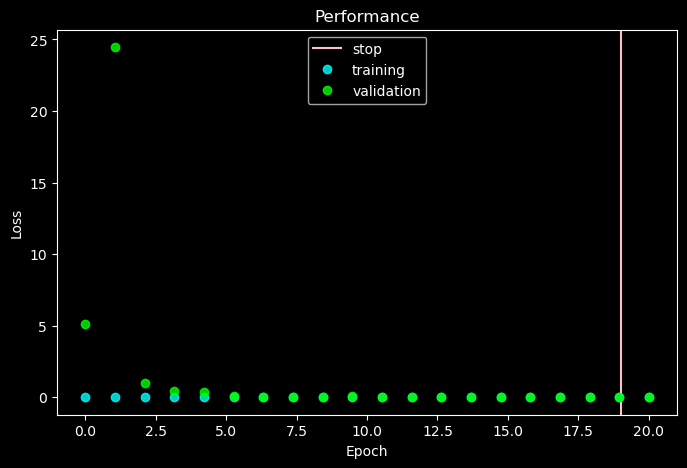

In [16]:
# Plotting complete training
data_model = pd.read_csv('Complete_model.csv')

plt.figure(figsize=(8,5))
plt.xlabel('Epoch')
plt.ylabel('Loss')
x = np.linspace(0, len(data_model), len(data_model))
plt.title('Performance')
plt.axvline(x = len(model.loss_train), label='stop', color='#FFC0CB')
plt.plot(x, data_model['train_losses'].values, 'o', label='training', color='#00FFFF', alpha=0.8)
plt.plot(x, data_model['valid_losses'].values, 'o', label='validation', color='#00FF00', alpha=0.8)
plt.legend()

if(script):
    plt.savefig('Performance.png', bbox_inches='tight')
    plt.close()
else: 
    plt.show(block=True)

In [17]:
def testing_analysis(test_loader):
    predicted_data, true_data = pd.DataFrame(), pd.DataFrame()
    for i, sample in enumerate(tqdm(test_loader)):
        data, target, sample_img, sample_data = sample['image'], sample['label'] , sample['img'], sample['data']
            
        # move tensors to GPU if CUDA is available
        if device.type == "cuda":
            data, target = data.cuda(), target.cuda()

        output = model.forward(data)
        output = pd.DataFrame(output.detach().numpy())
        
        predicted_data = predicted_data.append(output)
        true_data = true_data.append(pd.DataFrame(target.numpy()))
        
    return(predicted_data, true_data)

In [18]:
test_dataset = test_loader.dataset
test_images, test_data = test_dataset.images, test_dataset.data
test_data = test_data.reset_index(drop=True)

predicted_data, true_data = testing_analysis(test_loader)

  0%|          | 0/25 [00:00<?, ?it/s]

In [19]:
names = ['EINSTEIN_RADIUS', 'e1_lens', 'e2_lens', 'center_x_lens', 'center_y_lens', 'R_sersic_source_light',
       'n_sersic_source_light', 'e1_source_light', 'e2_source_light', 'center_x_source', 'center_y_source', 
        'R_sersic_lens_light', 'e1_lens_light', 'e2_lens_light']
column_mapping = {old_column: new_column for old_column, new_column in enumerate(names)}
predicted_data.rename(columns=column_mapping, inplace=True)
true_data.rename(columns=column_mapping, inplace=True)

In [20]:
new_test_data = pd.DataFrame(columns = true_data.columns)
for i in range(len(true_data)):
    closest_index = (test_data['EINSTEIN_RADIUS'] - true_data['EINSTEIN_RADIUS'].iloc[i]).abs().idxmin()
    closest_row = test_data.loc[closest_index]
    new_test_data = new_test_data.append(closest_row)
    
test_data = new_test_data
test_images = test_images[test_data.index]
test_data = test_data.reset_index(drop=True)

for name in names:
    loss_value = list((predicted_data[name]-true_data[name])**2)
    column_name = 'loss_' + name
    test_data[column_name] = loss_value
    
test_data['pred_EINSTEIN_RADIUS'] = list(predicted_data['EINSTEIN_RADIUS'])

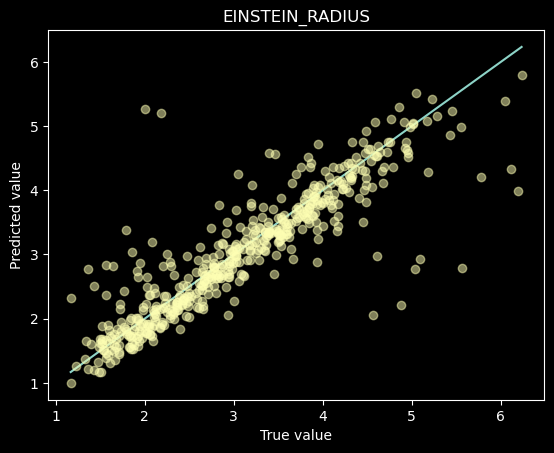

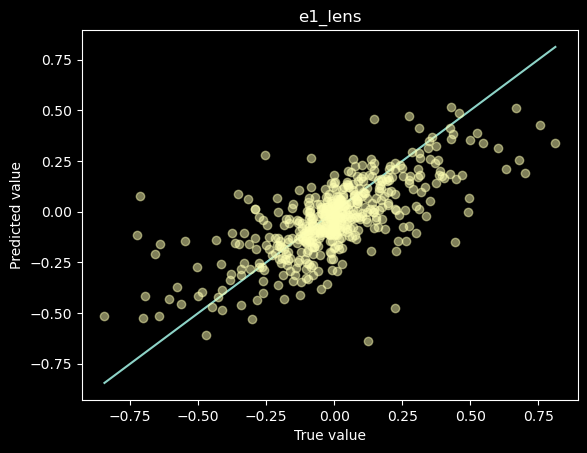

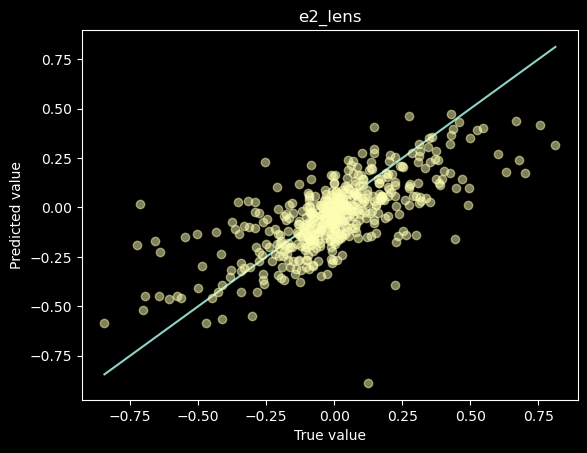

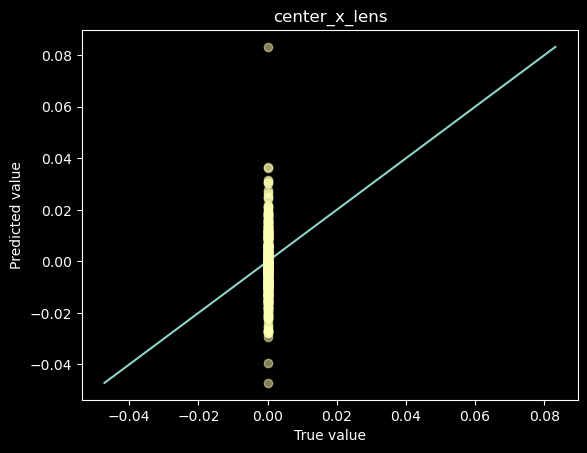

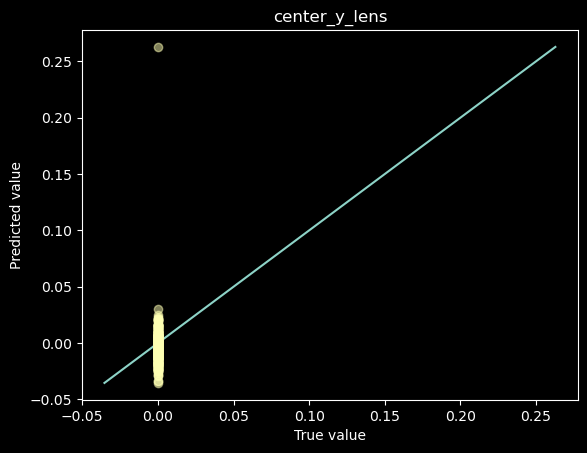

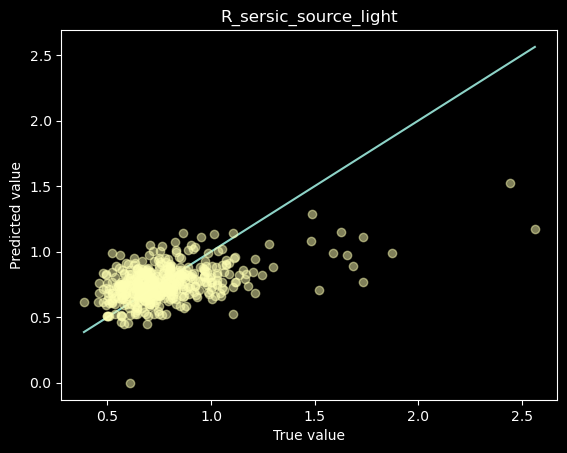

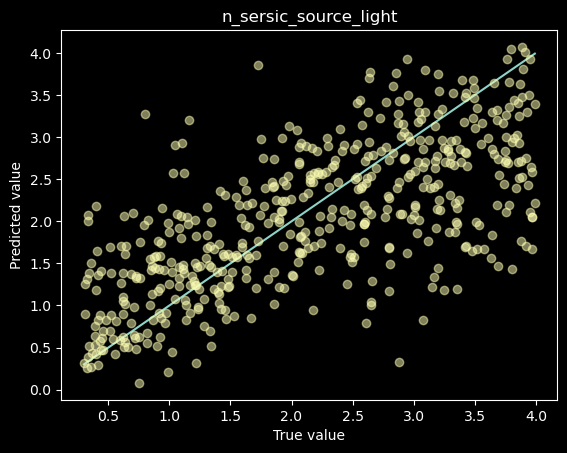

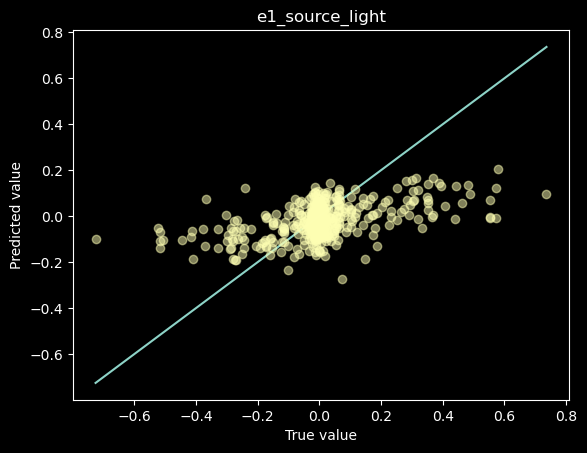

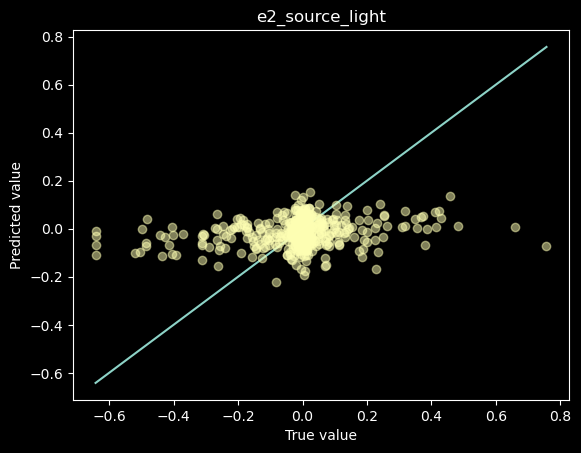

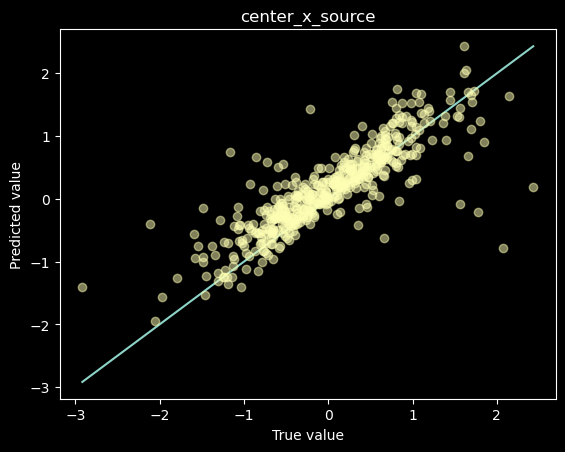

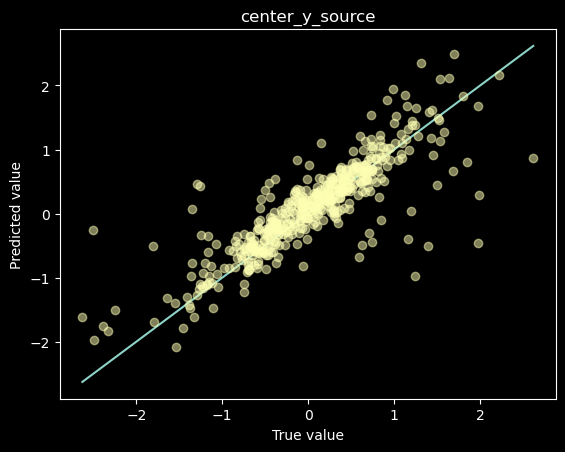

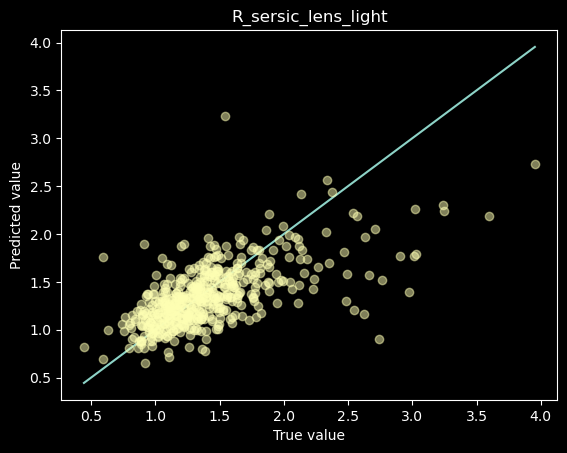

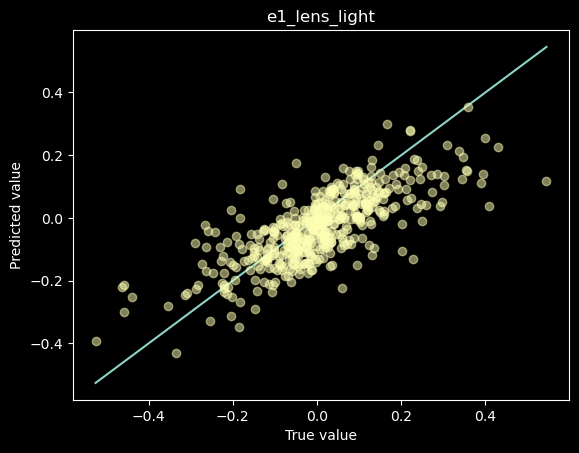

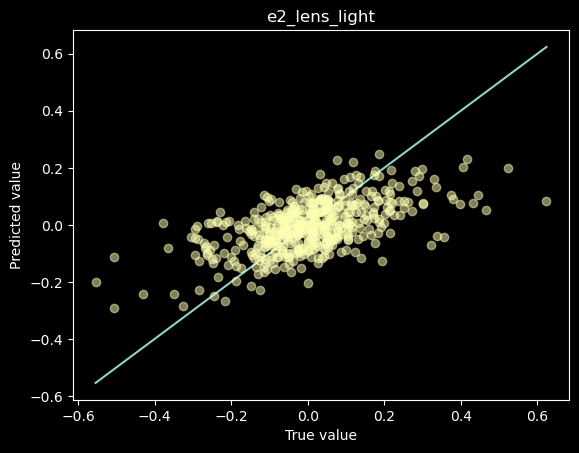

In [21]:
j = 0
for name in names:
    x = np.linspace(min(true_data[name]), max(true_data[name]), 1000)
    if(name == 'center_x_lens' or name == 'center_y_lens'):
        x = np.linspace(min(predicted_data[name]), max(predicted_data[name]), 1000)
    
    plt.figure()
    plt.title(name)
    plt.xlabel('True value')
    plt.ylabel('Predicted value')
    plt.plot(x, x)
    plt.plot(true_data[name], predicted_data[name], 'o', alpha = 0.5)
    
    if(script):
        plt.savefig('True_Predic_' + str(name) + '.png', bbox_inches='tight')
        plt.close()
    else:
        plt.show()
    j += 1

In [22]:
def make_plot_all(objects, title, data, Q, stretch, minimum):
    for i in range(len(objects)):
        if(i%7 == 0):
            plt.figure(figsize=(10,2))
            for j in range(7):
                if(i+j > len(objects)-1): break
                plt.subplot(1,7,j+1)
                #print(data['COADD_OBJECT_ID'].iloc[i+j]) 
                title = 'T:{:.1f}  P:{:.1f}'.format(data['EINSTEIN_RADIUS'].iloc[i+j], data['pred_EINSTEIN_RADIUS'].iloc[i+j])
                plt.title(title)
                rgb = make_lupton_rgb(objects[i+j][2], objects[i+j][1], objects[i+j][0], 
                                    Q=Q, stretch=stretch, minimum=minimum)
                plt.imshow(rgb, aspect='equal')
                plt.xticks([], [])
                plt.yticks([], []) 
            #plt.savefig(png_filepath + title + '.png', bbox_inches='tight')
            plt.show() 

worst


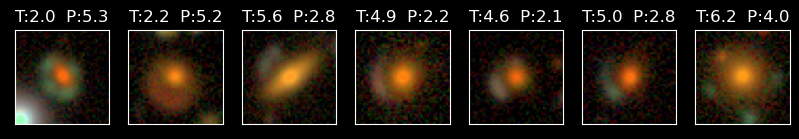

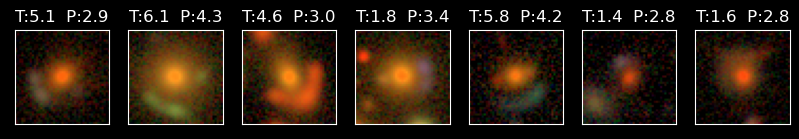

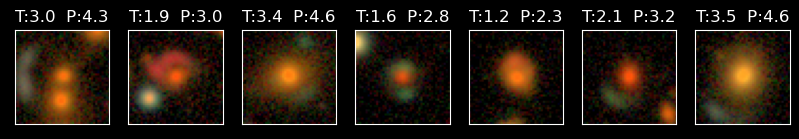

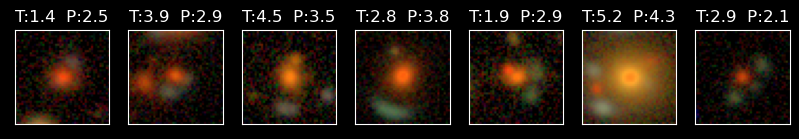

best


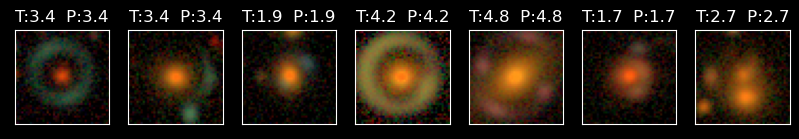

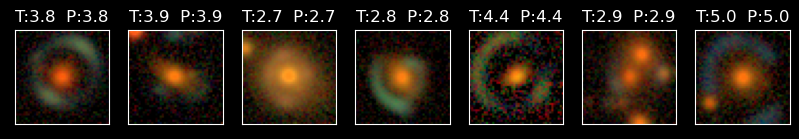

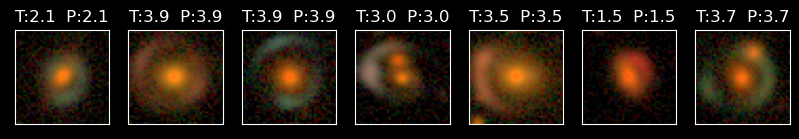

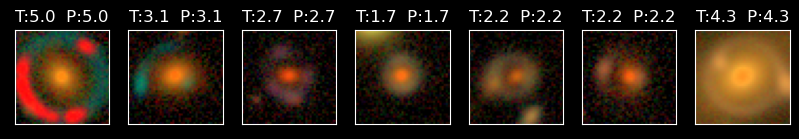

In [23]:
print('worst')
worst_data = test_data.nlargest(28, 'loss_EINSTEIN_RADIUS').sort_values(by='loss_EINSTEIN_RADIUS', ascending=False)
worst_images = test_images[worst_data.index]
make_plot_all(worst_images, 'title', worst_data, 9, 40, (0, 0, 0))

print('best')
worst_data = test_data.nsmallest(28, 'loss_EINSTEIN_RADIUS').sort_values(by='loss_EINSTEIN_RADIUS', ascending=True)
worst_images = test_images[worst_data.index]
make_plot_all(worst_images, 'title', worst_data, 9, 40, (0, 0, 0))

In [25]:
def make_histo(name):
    plt.figure(figsize=(16,5)) 

    plt.subplot(1,2,1)
    plt.title('All distribution: ' + str(name))
    #data_all = np.concatenate((right_pos[name], wrong_pos[name]))
    plt.hist(data_dataset[name], edgecolor = 'black')
    
    if(script):
        plt.savefig('Histogram_' + str(name), bbox_inches='tight')
        plt.close()
    else:
        plt.show()
        

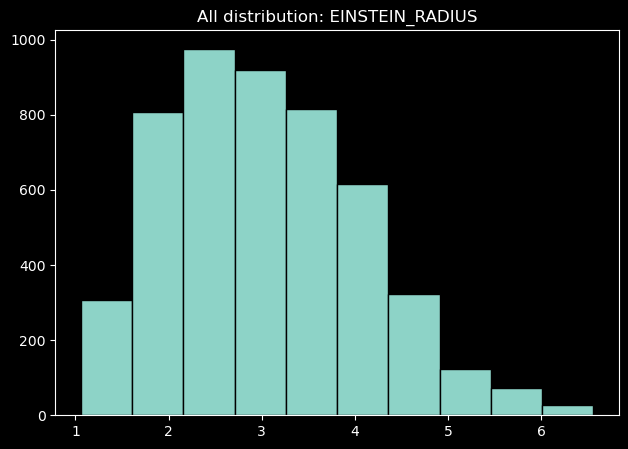

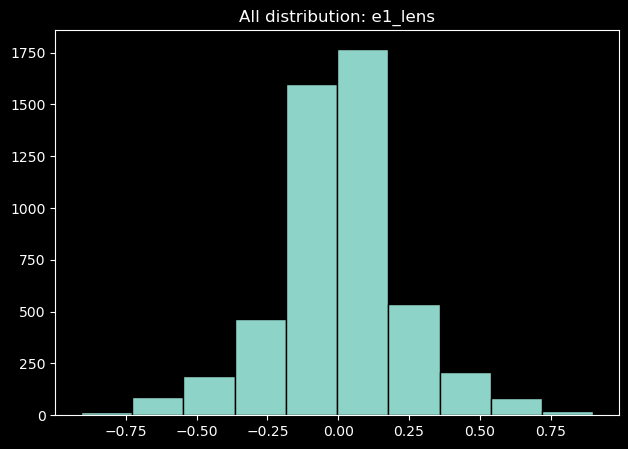

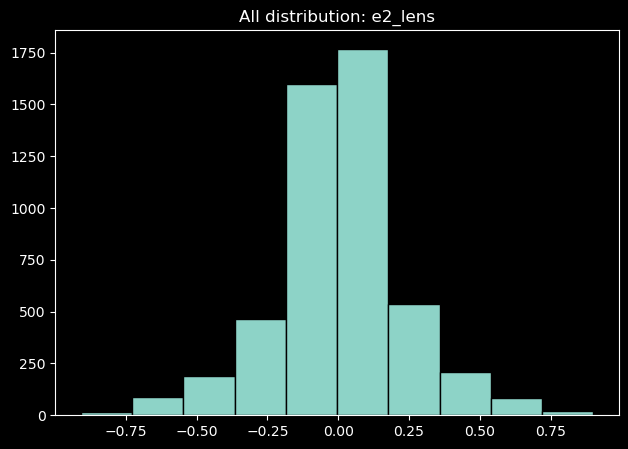

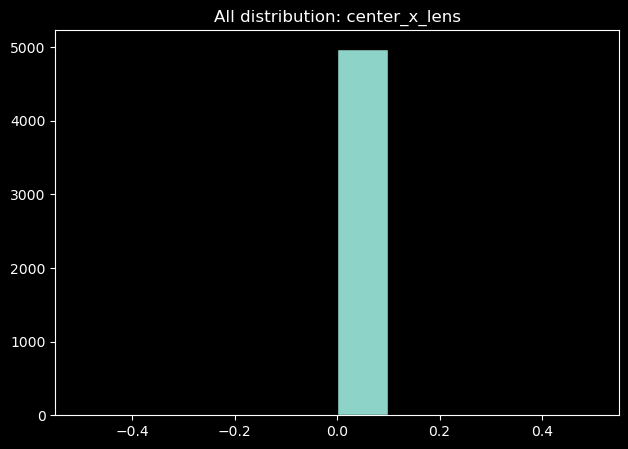

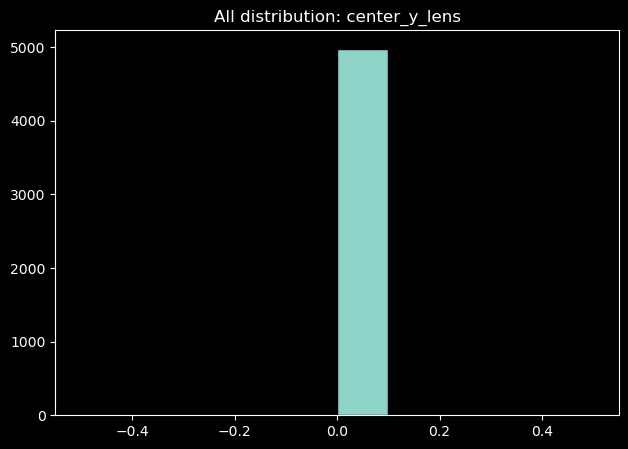

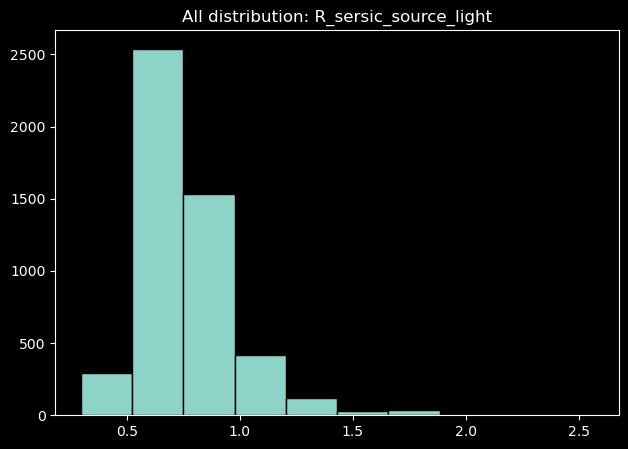

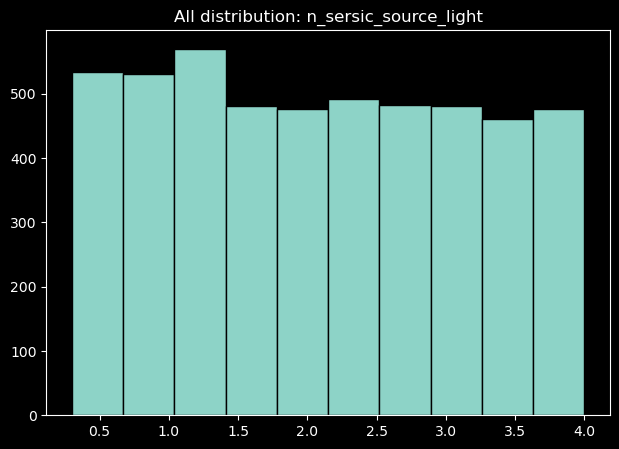

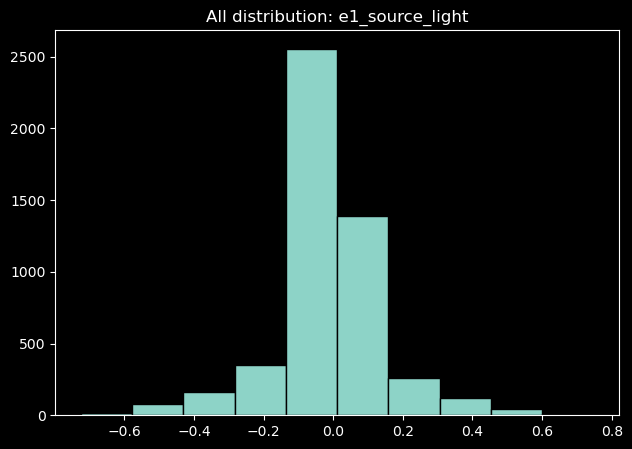

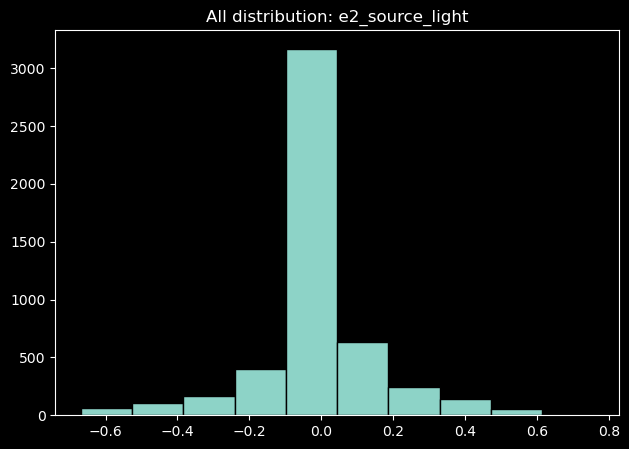

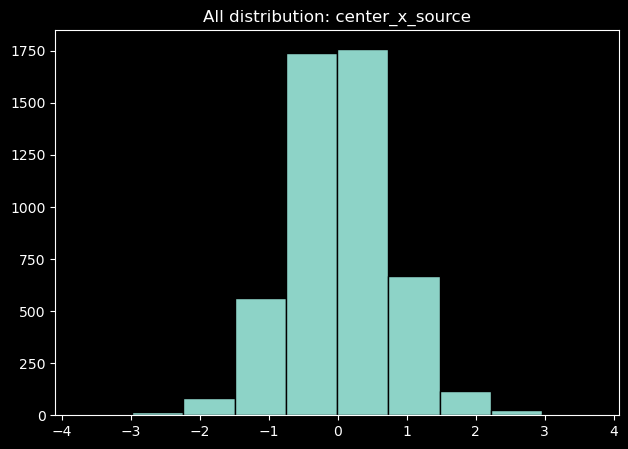

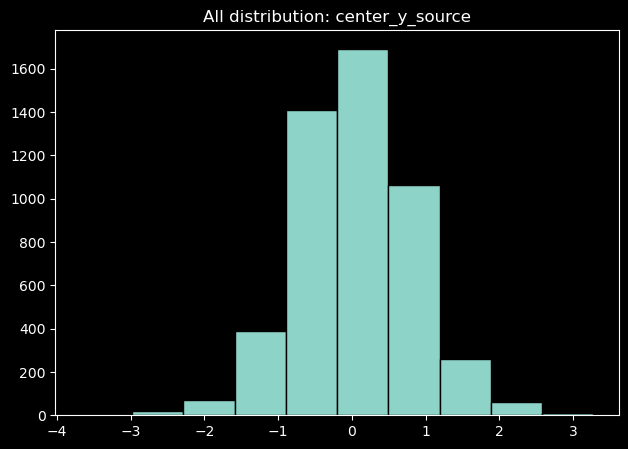

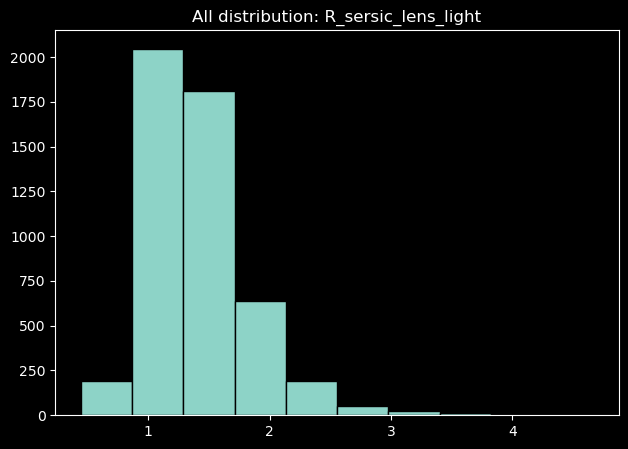

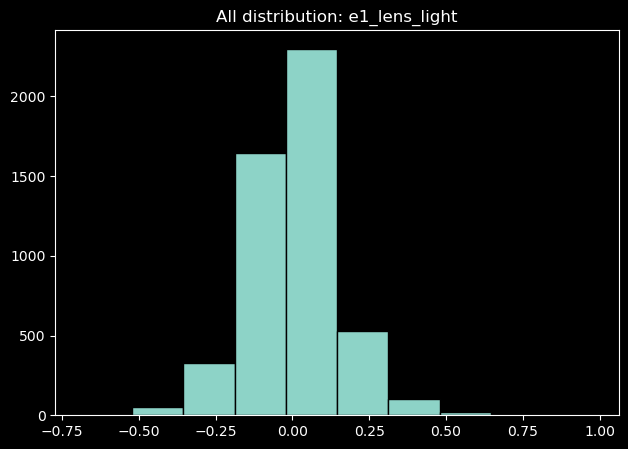

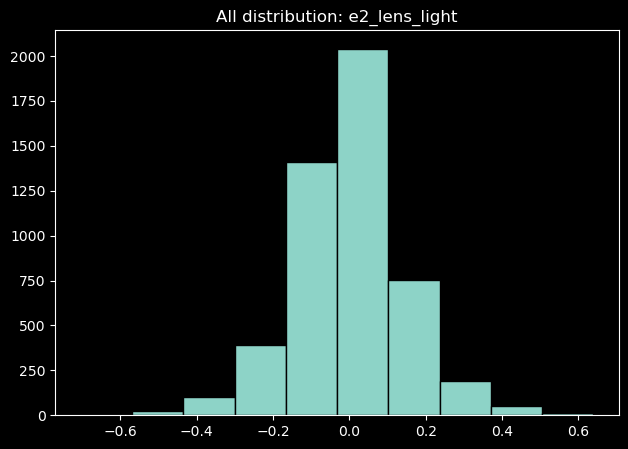

In [26]:
for name in names:
    make_histo(name)